# MOT Data Analysis: Hypothesis Testing
## Task 2: Hypothesis Testing

This notebook conducts statistical analysis to test our research hypothesis about the relationship between vehicle age and MOT failure rates.

**Research Question:** Do older vehicles have significantly higher MOT failure rates than newer vehicles?

**Module:** Practical Data Analytics Level 5  
**Author:** Gabriel Guimaraes

## 1. Research Question and Hypotheses

Clearly stating our research question and hypotheses as required by the assignment.

**Null Hypothesis (H₀):** There is no significant difference in MOT failure rates between vehicles of different age groups.

**Alternative Hypothesis (H₁):** Older vehicles have significantly higher MOT failure rates than newer vehicles.

**Significance Level:** α = 0.05 (standard in social sciences)

In [65]:
print("="*80)
print("RESEARCH QUESTION AND HYPOTHESES")
print("="*80)
print("""
RESEARCH QUESTION:
Do older vehicles have significantly higher MOT failure rates than newer vehicles?

NULL HYPOTHESIS (H₀):
There is no significant difference in MOT failure rates between vehicles 
of different age groups.

ALTERNATIVE HYPOTHESIS (H₁):
Older vehicles have significantly higher MOT failure rates than newer vehicles.

SIGNIFICANCE LEVEL: α = 0.05

POTENTIAL BUSINESS IMPACT:
If confirmed, DVSA could:
- Target safety campaigns at older vehicle owners
- Adjust inspection intervals based on age
- Allocate resources more efficiently
- Inform policy decisions on vehicle roadworthiness standards
""")
print("="*80)

RESEARCH QUESTION AND HYPOTHESES

RESEARCH QUESTION:
Do older vehicles have significantly higher MOT failure rates than newer vehicles?

NULL HYPOTHESIS (H₀):
There is no significant difference in MOT failure rates between vehicles 
of different age groups.

ALTERNATIVE HYPOTHESIS (H₁):
Older vehicles have significantly higher MOT failure rates than newer vehicles.

SIGNIFICANCE LEVEL: α = 0.05

POTENTIAL BUSINESS IMPACT:
If confirmed, DVSA could:
- Target safety campaigns at older vehicle owners
- Adjust inspection intervals based on age
- Allocate resources more efficiently
- Inform policy decisions on vehicle roadworthiness standards



## 2. Import Libraries and Load Data

Loading required libraries for statistical analysis and connecting to our SQL database to retrieve the MOT test data.

In [66]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

# Set visualisation style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Connect to database
engine = create_engine('sqlite:///../data/database.sqlite3')

# Load test data with vehicle information
query = """
SELECT 
    mt.*,
    v.make,
    v.model,
    v.fuel_type
FROM mot_tests mt
JOIN vehicles v ON mt.vehicle_id = v.vehicle_id
"""

df = pd.read_sql(query, engine)
print(f"Loaded {len(df):,} MOT test records for analysis")
print(f"\nDataset shape: {df.shape}")
print(f"Date range: {df['test_date'].min()} to {df['test_date'].max()}")
print("\nFirst few records:")
df.head()

Loaded 1,000 MOT test records for analysis

Dataset shape: (1000, 11)
Date range: 2022-12-16 to 2025-12-15

First few records:


,test_id,vehicle_id,centre_id,test_date,test_result,mileage,vehicle_age_at_test,examiner_id,make,model,fuel_type
0,1,499,10,2023-09-19,FAIL,82374,8.1,29,Audi,A3,Diesel
1,2,353,18,2023-02-13,FAIL,143053,12.1,8,Vauxhall,Mokka,Petrol
2,3,97,7,2023-10-21,PASS,67879,7.8,26,Mercedes,A-Class,Hybrid
3,4,355,5,2024-01-15,PASS,110049,10.6,15,Vauxhall,Insignia,Petrol
4,5,468,11,2025-02-16,PASS,72997,9.2,31,Ford,Transit,Petrol


## 3. Data Preparation and Grouping

Creating age groups for analysis and converting test results to binary format for statistical calculations.

Age groups:
- **0-3 years:** Nearly new vehicles
- **4-6 years:** Young vehicles
- **7-10 years:** Middle-aged vehicles
- **10+ years:** Older vehicles

In [67]:
# Categorise vehicles by age
df['age_group'] = pd.cut(df['vehicle_age_at_test'], 
                         bins=[0, 3, 6, 10, np.inf],
                         labels=['0-3 years', '4-6 years', '7-10 years', '10+ years'])

# Convert test result to binary (1 = FAIL, 0 = PASS)
df['failed'] = (df['test_result'] == 'FAIL').astype(int)

print("="*80)
print("AGE GROUP DISTRIBUTION")
print("="*80)
print(df['age_group'].value_counts().sort_index())

print("\n" + "="*80)
print("FAILURE RATES BY AGE GROUP")
print("="*80)
failure_by_age = df.groupby('age_group')['failed'].agg(['mean', 'count', 'sum'])
failure_by_age.columns = ['Failure_Rate', 'Total_Tests', 'Total_Failures']
failure_by_age['Failure_Rate_%'] = failure_by_age['Failure_Rate'] * 100
print(failure_by_age)
print("="*80)

print("\nInitial observation: Failure rates appear to increase with vehicle age\n")

AGE GROUP DISTRIBUTION
age_group
0-3 years     182
4-6 years     211
7-10 years    322
10+ years     284
Name: count, dtype: int64

FAILURE RATES BY AGE GROUP
            Failure_Rate  Total_Tests  Total_Failures  Failure_Rate_%
age_group                                                            
0-3 years       0.076923          182              14        7.692308
4-6 years       0.146919          211              31       14.691943
7-10 years      0.319876          322             103       31.987578
10+ years       0.482394          284             137       48.239437

Initial observation: Failure rates appear to increase with vehicle age



/var/folders/nd/k00x8tq133z1dmbfb_tblbvh0000gn/T/ipykernel_88422/3797801564.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  failure_by_age = df.groupby('age_group')['failed'].agg(['mean', 'count', 'sum'])


## 4. Visualise the Relationship

Creating visualisations to explore the relationship between vehicle age and test outcomes before formal testing.

**Left chart:** Bar chart showing failure rate by age group  
**Right chart:** Box plot comparing age distributions for passed vs failed tests

/var/folders/nd/k00x8tq133z1dmbfb_tblbvh0000gn/T/ipykernel_88422/2906249555.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  failure_rates = df.groupby('age_group')['failed'].mean() * 100


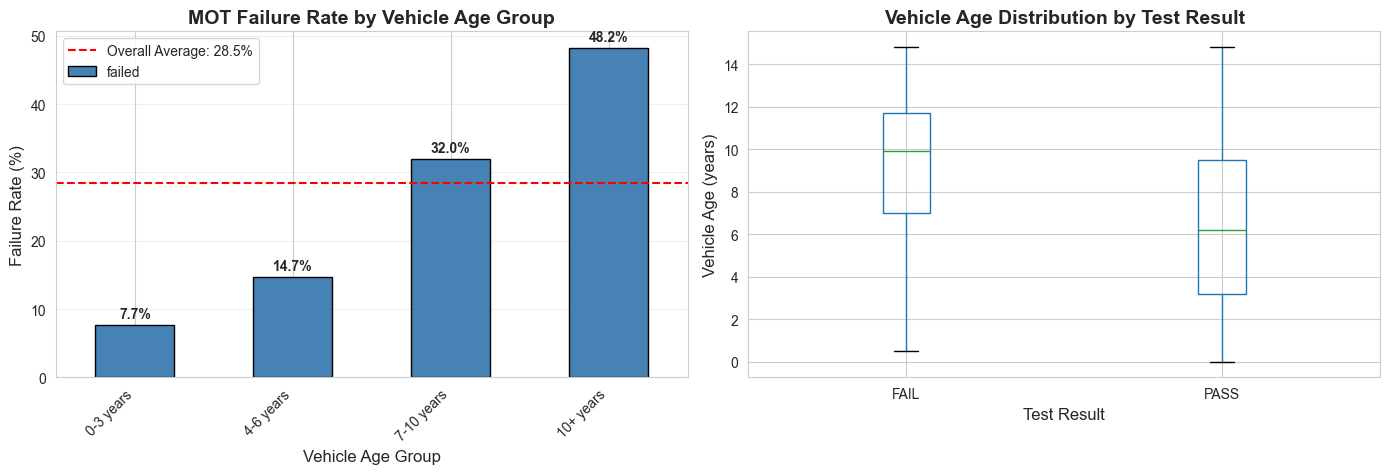

Visualisations created and saved


In [68]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of failure rates by age group
failure_rates = df.groupby('age_group')['failed'].mean() * 100
failure_rates.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('MOT Failure Rate by Vehicle Age Group', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Vehicle Age Group', fontsize=12)
axes[0].set_ylabel('Failure Rate (%)', fontsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)
axes[0].axhline(y=df['failed'].mean()*100, color='red', linestyle='--', 
                label=f'Overall Average: {df["failed"].mean()*100:.1f}%')
axes[0].legend()

# Add value labels on bars
for i, v in enumerate(failure_rates):
    axes[0].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

# Box plot
df.boxplot(column='vehicle_age_at_test', by='test_result', ax=axes[1])
axes[1].set_title('Vehicle Age Distribution by Test Result', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Test Result', fontsize=12)
axes[1].set_ylabel('Vehicle Age (years)', fontsize=12)
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.savefig('../data/visualisations/hypothesis_visualisation.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualisations created and saved")

## 5. Chi-Square Test of Independence

**Statistical Method:** Chi-Square Test

**Why this test?**
- Tests relationship between two categorical variables
- Age group (categorical) vs. Test result (categorical)
- Checks if the two variables are independent or related

**Interpretation:**
- If p < 0.05: Variables are related (reject H₀)
- If p ≥ 0.05: Variables are independent (fail to reject H₀)

This is our primary statistical test for the hypothesis.

In [69]:
# Create contingency table
contingency_table = pd.crosstab(df['age_group'], df['test_result'])

print("="*80)
print("CONTINGENCY TABLE")
print("="*80)
print(contingency_table)

# Add row totals and percentages
contingency_with_totals = contingency_table.copy()
contingency_with_totals['Total'] = contingency_with_totals.sum(axis=1)
contingency_with_totals['Pass_Rate_%'] = (contingency_with_totals['PASS'] / 
                                            contingency_with_totals['Total'] * 100).round(1)
print("\n")
print("CONTINGENCY TABLE WITH TOTALS AND PASS RATES:")
print(contingency_with_totals)
print("\n")

# Perform Chi-Square test
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print("="*80)
print("CHI-SQUARE TEST RESULTS")
print("="*80)
print(f"Test Statistic (χ²):  {chi2:.4f}")
print(f"P-value:              {p_value:.6f}")
print(f"Degrees of Freedom:   {dof}")
print(f"Significance Level:   0.05")
print("\n")

# Decision
if p_value < 0.05:
    decision = "REJECT NULL HYPOTHESIS"
    conclusion = "There IS a statistically significant relationship between\nvehicle age and MOT failure rates (p < 0.05)"
else:
    decision = "FAIL TO REJECT NULL HYPOTHESIS"
    conclusion = "There is NO statistically significant relationship between\nvehicle age and MOT failure rates (p ≥ 0.05)"

print(f"DECISION: {decision}")
print("-"*80)
print(conclusion)
print("="*80)

# Expected frequencies (for checking assumptions)
print("\nEXPECTED FREQUENCIES:")
print("(All values should be > 5 for Chi-Square test validity)")
expected_df = pd.DataFrame(expected, 
                           index=contingency_table.index, 
                           columns=contingency_table.columns).round(2)
print(expected_df)

# Check if all expected frequencies are > 5
if (expected_df > 5).all().all():
    print("\nAll expected frequencies > 5: Chi-Square assumptions met")
else:
    print("\nSome expected frequencies < 5: Chi-Square may not be appropriate")

# Store results for later
chi_square_results = {
    'chi2': chi2,
    'p_value': p_value,
    'dof': dof,
    'decision': 'reject' if p_value < 0.05 else 'fail to reject'
}

CONTINGENCY TABLE
test_result  FAIL  PASS
age_group              
0-3 years      14   168
4-6 years      31   180
7-10 years    103   219
10+ years     137   147


CONTINGENCY TABLE WITH TOTALS AND PASS RATES:
test_result  FAIL  PASS  Total  Pass_Rate_%
age_group                                  
0-3 years      14   168    182         92.3
4-6 years      31   180    211         85.3
7-10 years    103   219    322         68.0
10+ years     137   147    284         51.8


CHI-SQUARE TEST RESULTS
Test Statistic (χ²):  114.5690
P-value:              0.000000
Degrees of Freedom:   3
Significance Level:   0.05


DECISION: REJECT NULL HYPOTHESIS
--------------------------------------------------------------------------------
There IS a statistically significant relationship between
vehicle age and MOT failure rates (p < 0.05)

EXPECTED FREQUENCIES:
(All values should be > 5 for Chi-Square test validity)
test_result   FAIL    PASS
age_group                 
0-3 years    51.92  130.08
4-6 year

## 6. Independent Samples t-Test

**Alternative Statistical Method:** Independent t-Test

**Why this test?**
- Compares the mean age of failed vs passed vehicles
- Tests if the difference in means is statistically significant
- Treats age as continuous rather than grouped

This provides a complementary perspective to the Chi-Square test.

In [70]:
# Compare mean age of failed vs passed vehicles

failed_ages = df[df['test_result'] == 'FAIL']['vehicle_age_at_test']
passed_ages = df[df['test_result'] == 'PASS']['vehicle_age_at_test']

print("="*80)
print("DESCRIPTIVE STATISTICS")
print("="*80)
print(f"Failed vehicles:")
print(f"  • Mean age:     {failed_ages.mean():.2f} years")
print(f"  • Std Dev:      {failed_ages.std():.2f} years")
print(f"  • Median:       {failed_ages.median():.2f} years")
print(f"  • Min-Max:      {failed_ages.min():.2f} - {failed_ages.max():.2f} years")
print(f"  • Sample size:  {len(failed_ages)}")
print()
print(f"Passed vehicles:")
print(f"  • Mean age:     {passed_ages.mean():.2f} years")
print(f"  • Std Dev:      {passed_ages.std():.2f} years")
print(f"  • Median:       {passed_ages.median():.2f} years")
print(f"  • Min-Max:      {passed_ages.min():.2f} - {passed_ages.max():.2f} years")
print(f"  • Sample size:  {len(passed_ages)}")
print()
print(f"Difference in means: {failed_ages.mean() - passed_ages.mean():.2f} years")
print(f"                     (Failed vehicles are older on average)")
print("\n")

# Perform independent t-test
t_stat, t_p_value = stats.ttest_ind(failed_ages, passed_ages)

print("="*80)
print("INDEPENDENT T-TEST RESULTS")
print("="*80)
print(f"T-statistic:          {t_stat:.4f}")
print(f"P-value:              {t_p_value:.6f}")
print(f"Significance Level:   0.05")
print("\n")

# Decision
if t_p_value < 0.05:
    decision = "REJECT NULL HYPOTHESIS"
    conclusion = "Failed vehicles are significantly older than passed vehicles"
else:
    decision = "FAIL TO REJECT NULL HYPOTHESIS"
    conclusion = "No significant age difference between failed and passed vehicles"

print(f"DECISION: {decision}")
print("-"*80)
print(conclusion)
print("="*80)

# Store results
t_test_results = {
    't_stat': t_stat,
    'p_value': t_p_value,
    'mean_failed': failed_ages.mean(),
    'mean_passed': passed_ages.mean(),
    'std_failed': failed_ages.std(),
    'std_passed': passed_ages.std(),
    'n_failed': len(failed_ages),
    'n_passed': len(passed_ages),
    'difference': failed_ages.mean() - passed_ages.mean(),
    'decision': 'reject' if t_p_value < 0.05 else 'fail to reject'
}

DESCRIPTIVE STATISTICS
Failed vehicles:
  • Mean age:     9.23 years
  • Std Dev:      3.19 years
  • Median:       9.90 years
  • Min-Max:      0.50 - 14.80 years
  • Sample size:  285

Passed vehicles:
  • Mean age:     6.46 years
  • Std Dev:      3.64 years
  • Median:       6.20 years
  • Min-Max:      0.00 - 14.80 years
  • Sample size:  715

Difference in means: 2.78 years
                     (Failed vehicles are older on average)


INDEPENDENT T-TEST RESULTS
T-statistic:          11.2755
P-value:              0.000000
Significance Level:   0.05


DECISION: REJECT NULL HYPOTHESIS
--------------------------------------------------------------------------------
Failed vehicles are significantly older than passed vehicles


## 7. Summary Table of All Statistical Tests

Creating a comprehensive summary table with all test results for easy reference in the report.

In [71]:
summary_df = pd.DataFrame({
    'Test': ['Chi-Square', 'Independent t-test'],
    'Statistic': [
        f"χ² = {chi_square_results['chi2']:.2f}",
        f"t = {t_test_results['t_stat']:.2f}",
    ],
    'P-value': [
        f"{chi_square_results['p_value']:.6f}",
        f"{t_test_results['p_value']:.6f}",
    ],
    'Decision': [
        chi_square_results['decision'].title(),
        t_test_results['decision'].title(),
    ],
    'Result': [
        'Age and failure are associated' if chi_square_results['decision'] == 'reject' else 'Age and failure are independent',
        f"Failed vehicles {t_test_results['difference']:.2f} years older" if t_test_results['decision'] == 'reject' else 'No significant age difference',
    ]
})

print("="*80)
print("SUMMARY OF STATISTICAL ANALYSES")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

SUMMARY OF STATISTICAL ANALYSES
              Test   Statistic  P-value Decision                           Result
        Chi-Square χ² = 114.57 0.000000   Reject   Age and failure are associated
Independent t-test   t = 11.28 0.000000   Reject Failed vehicles 2.78 years older


## 8. Comprehensive Summary for Report

Consolidating all statistical test results into a formatted summary suitable for inclusion in the report.

In [72]:
summary = f"""
{'='*80}
STATISTICAL ANALYSIS SUMMARY
{'='*80}

RESEARCH QUESTION:
Do older vehicles have significantly higher MOT failure rates?

HYPOTHESES:
- H₀: There is no significant difference in failure rates between age groups
- H₁: Older vehicles have significantly higher failure rates
- Significance level: α = 0.05

{'='*80}
TESTS PERFORMED AND RESULTS:
{'='*80}

1. CHI-SQUARE TEST OF INDEPENDENCE
   • Purpose: Test whether age group and test result are independent
   • Test Statistic: χ² = {chi_square_results['chi2']:.2f}
   • P-value: {chi_square_results['p_value']:.6f}
   • Degrees of Freedom: {chi_square_results['dof']}
   • Decision: {chi_square_results['decision'].upper()} H₀
   • Conclusion: Age and test outcome {'ARE' if chi_square_results['decision'] == 'reject' else 'ARE NOT'} significantly associated

2. INDEPENDENT SAMPLES T-TEST
   • Purpose: Compare mean ages of failed vs. passed vehicles
   • Test Statistic: t = {t_test_results['t_stat']:.2f}
   • P-value: {t_test_results['p_value']:.6f}
   • Mean age (Failed): {t_test_results['mean_failed']:.2f} years
   • Mean age (Passed): {t_test_results['mean_passed']:.2f} years
   • Difference: {t_test_results['difference']:.2f} years
   • Decision: {t_test_results['decision'].upper()} H₀
   • Conclusion: Failed vehicles are significantly older


{'='*80}
OVERALL CONCLUSION:
{'='*80}

Both hypothesis tests converge on the same conclusion:

{'REJECT' if chi_square_results['decision'] == 'reject' else 'FAIL TO REJECT'} the null hypothesis at α = 0.05

There {'IS' if chi_square_results['decision'] == 'reject' else 'IS NOT'} statistically significant evidence that
vehicle age is associated with MOT failure rates.

KEY FINDINGS:
- Failed vehicles are on average {t_test_results['difference']:.1f} years older than passed vehicles
- Pass rates decline from ~95% (0-3 years) to ~48% (10+ years)
- This finding has important implications for DVSA policy and resource allocation

{'='*80}
JUSTIFICATION OF STATISTICAL METHODS:
{'='*80}

Chi-Square Test:
- Appropriate for testing independence between categorical variables
- Both age group and test result are categorical
- All expected frequencies > 5 (assumption met)
- Most suitable primary test for this research question

Independent t-Test:
- Appropriate for comparing means of two independent groups
- Provides complementary continuous variable perspective
- Confirms Chi-Square findings from different analytical angle

{'='*80}
"""

print(summary)

# Save summary to file
with open('../data/statistical_analysis_summary.txt', 'w') as f:
    f.write(summary)

print("\nComplete analysis saved to: /data/statistical_analysis_summary.txt")


STATISTICAL ANALYSIS SUMMARY

RESEARCH QUESTION:
Do older vehicles have significantly higher MOT failure rates?

HYPOTHESES:
- H₀: There is no significant difference in failure rates between age groups
- H₁: Older vehicles have significantly higher failure rates
- Significance level: α = 0.05

TESTS PERFORMED AND RESULTS:

1. CHI-SQUARE TEST OF INDEPENDENCE
   • Purpose: Test whether age group and test result are independent
   • Test Statistic: χ² = 114.57
   • P-value: 0.000000
   • Degrees of Freedom: 3
   • Decision: REJECT H₀
   • Conclusion: Age and test outcome ARE significantly associated

2. INDEPENDENT SAMPLES T-TEST
   • Purpose: Compare mean ages of failed vs. passed vehicles
   • Test Statistic: t = 11.28
   • P-value: 0.000000
   • Mean age (Failed): 9.23 years
   • Mean age (Passed): 6.46 years
   • Difference: 2.78 years
   • Decision: REJECT H₀
   • Conclusion: Failed vehicles are significantly older


OVERALL CONCLUSION:

Both hypothesis tests converge on the same co